# Generating figures for paper

In [477]:
import pandas as pd
import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

fsize = 8
tsize = 8
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('grid')
# plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# errbar_kwargs = dict(marker='.', markersize=3, capsize=3, elinewidth=1, lw=1)
# plot_kwargs = dict(marker='.', markersize=3, lw=1)
# errband_kwargs = dict(alpha=0.25)
errbar_kwargs = dict(estimator='mean', errorbar=('ci', 95), errwidth=1.25, capsize=0.05,)

save_dir = '../neurips/figs/experiments'

In [478]:
cmap = plt.cm.tab20

In [479]:
our_model_name = 'AbstractTransformer' # Orphrus

## Relational Games

In [480]:
relgames_data = pd.read_csv('figure_data/relgames/relgames_data.csv')

def process_groupname(group_name):
    task, model_name = group_name.split('__')
    return model_name


L, total_n_heads = 2, 2
filter_ = (relgames_data['n_layers'] == L) & ((relgames_data['n_heads_rca'] + relgames_data['n_heads_sa'] == total_n_heads) | (relgames_data['n_heads'] == total_n_heads)) & (relgames_data['train_size'] <= 25_000)
figure_data = relgames_data[filter_]

figure_data['Model'] = figure_data['group'].apply(process_groupname)

figure_data.rename(columns={'train_size': 'Training Set Size', 'test/acc_in_distribution': 'Generalization Accuracy', 'task': 'Task'}, inplace=True)

In [481]:
def parse_rel_symmetry(group_name):
    if 'sym_rel=True' in group_name:
        return True
    elif 'sym_rel=False' in group_name:
        return False
    else:
        return None

figure_data['Symmetric RA'] = figure_data['group'].apply(parse_rel_symmetry)

In [482]:
models = [
    'sa=2; d=128; L=2',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever',
    'sa=1; rca=1; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever',
    ]
model_name_map = {
    'sa=2; d=128; L=2': 'Transformer ($n_h^{sa}=2, n_h^{ra}=0$)',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever': f'{our_model_name} ($n_h^{{sa}}=1, n_h^{{ra}}=1$)',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever': f'{our_model_name} ($n_h^{{sa}}=0, n_h^{{ra}}=2$)',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever': f'{our_model_name} [asymmetric] ($n_h^{{sa}}=1, n_h^{{ra}}=1$)',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever': f'{our_model_name} [asymmetric] ($n_h^{{sa}}=0, n_h^{{ra}}=2$)',
    'sa=1; rca=1; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever': "Abstractor's RCA ($n_h^{{sa}}=1, n_h^{{ra}}=1$)",
    'sa=0; rca=2; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever': "Abstractor's RCA ($n_h^{{sa}}=0, n_h^{{ra}}=2$)",
    }
models = [model_name_map[m] for m in models]

tasks = ['same', 'occurs', 'xoccurs', '1task_between', '1task_match_patt']
task_name_map = {
    '1task_between': r'$\texttt{between}$', '1task_match_patt': r'$\texttt{match pattern}$',
    'same': r'$\texttt{same}$', 'occurs': r'$\texttt{occurs}$', 'xoccurs': r'$\texttt{xoccurs}$'}
tasks = [task_name_map[t] for t in tasks]

figure_data['Model'] = pd.Categorical(figure_data['Model'].map(model_name_map), models, ordered=True)
figure_data['Task'] = pd.Categorical(figure_data['Task'].map(task_name_map), tasks, ordered=True)


# bar plot figure
color_map_ = {
    f'{our_model_name} ($n_h^{{sa}}=1, n_h^{{ra}}=1$)': cmap(8), # purple
    f'{our_model_name} ($n_h^{{sa}}=0, n_h^{{ra}}=2$)': cmap(0), # blue
    f'{our_model_name} [asymmetric] ($n_h^{{sa}}=1, n_h^{{ra}}=1$)': cmap(8), # purple
    f'{our_model_name} [asymmetric] ($n_h^{{sa}}=0, n_h^{{ra}}=2$)': cmap(0), # blue
    'Transformer ($n_h^{sa}=2, n_h^{ra}=0$)': cmap(6), # red
    "Abstractor's RCA ($n_h^{{sa}}=1, n_h^{{ra}}=1$)": cmap(8),
    "Abstractor's RCA ($n_h^{{sa}}=0, n_h^{{ra}}=2$)": cmap(0),
    # 'Transformer+': cmap(4),
    }


In [483]:
figure_data.groupby(['group', 'Task', 'Training Set Size'])['Generalization Accuracy'].count().value_counts()

0     2982
5      196
10     140
11       3
8        2
7        1
9        1
Name: Generalization Accuracy, dtype: int64

In [484]:
model_name_map.values()

dict_values(['Transformer ($n_h^{sa}=2, n_h^{ra}=0$)', 'AbstractTransformer ($n_h^{sa}=1, n_h^{ra}=1$)', 'AbstractTransformer ($n_h^{sa}=0, n_h^{ra}=2$)', 'AbstractTransformer [asymmetric] ($n_h^{sa}=1, n_h^{ra}=1$)', 'AbstractTransformer [asymmetric] ($n_h^{sa}=0, n_h^{ra}=2$)', "Abstractor's RCA ($n_h^{{sa}}=1, n_h^{{ra}}=1$)", "Abstractor's RCA ($n_h^{{sa}}=0, n_h^{{ra}}=2$)"])

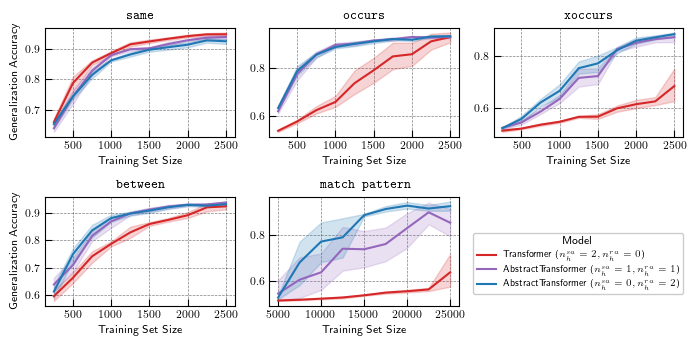

In [485]:
fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]
    # config filter
    ax_data = ax_data[ax_data['Symmetric RA']!=False]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.15), fontsize='medium', title='Model')
fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.68, 0.15), fontsize='small', title='Model') # TODO: make larger? go back to medium
fig.set_tight_layout(True)
# fig.savefig(f'{save_dir}/relgames_learning_curves.pdf')

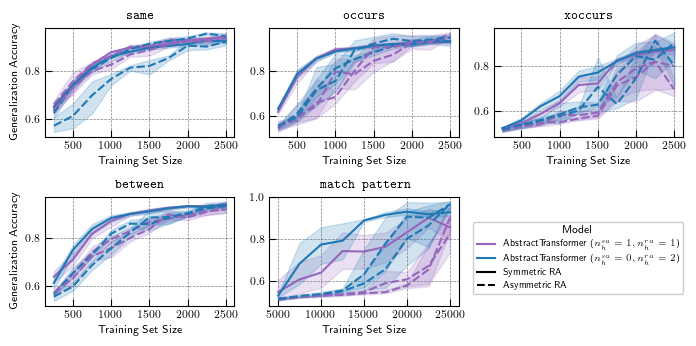

In [486]:
fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]
    # config filter
    ax_data = ax_data[~ax_data['Symmetric RA'].isna()]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', style='Symmetric RA', style_order=[True, False], legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.15), fontsize='medium', title='Model')
# create custom legend
from matplotlib.lines import Line2D
legend_elements = [*ax.get_lines()[:2], Line2D([0], [0], color='black', linestyle='-', label='Symmetric RA'), Line2D([0], [0], color='black', linestyle='--', label='Asymmetric RA')]
legend_labels = [*models[1:3], 'Symmetric RA', 'Asymmetric RA']

fig.legend(handles=legend_elements, labels=legend_labels,  loc=(0.68, 0.15), fontsize='small', title='Model') # TODO: make larger? go back to medium
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_symmetry_ablation.pdf')

In [487]:
list(ax_data.Model.unique())

["Abstractor's RCA ($n_h^{{sa}}=0, n_h^{{ra}}=2$)",
 "Abstractor's RCA ($n_h^{{sa}}=1, n_h^{{ra}}=1$)",
 'AbstractTransformer [asymmetric] ($n_h^{sa}=1, n_h^{ra}=1$)',
 'AbstractTransformer [asymmetric] ($n_h^{sa}=0, n_h^{ra}=2$)',
 'AbstractTransformer ($n_h^{sa}=1, n_h^{ra}=1$)',
 'AbstractTransformer ($n_h^{sa}=0, n_h^{ra}=2$)']

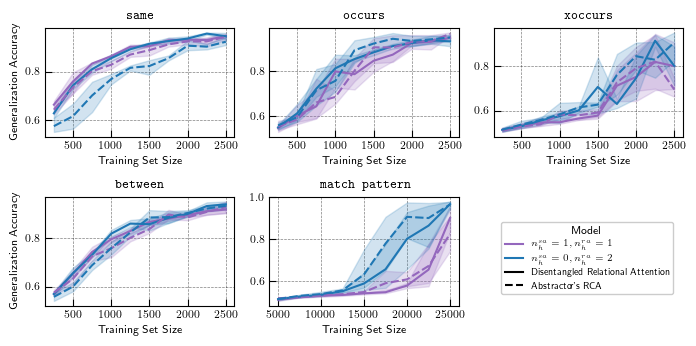

In [488]:
fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]
    # config filter
    ax_data = ax_data[ax_data['Symmetric RA']==False]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', style='rca_type', style_order=['disentangled_v2', 'standard'], legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.15), fontsize='medium', title='Model')
# create custom legend
from matplotlib.lines import Line2D
legend_elements = [*ax.get_lines()[:2], Line2D([0], [0], color='black', linestyle='-', label='Symmetric RA'), Line2D([0], [0], color='black', linestyle='--', label='Asymmetric RA')]
legend_labels = ['$n_h^{{sa}}=1, n_h^{{ra}}=1$', '$n_h^{{sa}}=0, n_h^{{ra}}=2$', 'Disentangled Relational Attention', "Abstractor's RCA"]

fig.legend(handles=legend_elements, labels=legend_labels,  loc=(0.72, 0.15), fontsize='small', title='Model') # TODO: make larger? go back to medium
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_rcatype_ablation.pdf')

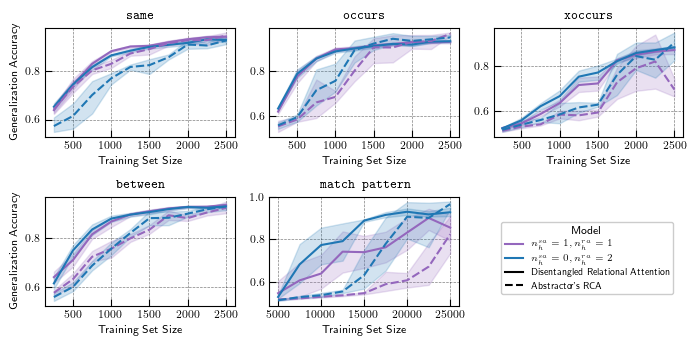

In [489]:
# Symmetric DisRA vs Asymmetric Abstractor's RCA
model_filter =[
    "Abstractor's RCA ($n_h^{{sa}}=0, n_h^{{ra}}=2$)",
    "Abstractor's RCA ($n_h^{{sa}}=1, n_h^{{ra}}=1$)",
    "AbstractTransformer ($n_h^{sa}=1, n_h^{ra}=1$)",
    "AbstractTransformer ($n_h^{sa}=0, n_h^{ra}=2$)"]

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]
    # config filter
    ax_data = ax_data[ax_data['Model'].isin(model_filter)]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', style='rca_type', style_order=['disentangled_v2', 'standard'], legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.15), fontsize='medium', title='Model')
# create custom legend
from matplotlib.lines import Line2D
legend_elements = [*ax.get_lines()[:2], Line2D([0], [0], color='black', linestyle='-', label='Symmetric RA'), Line2D([0], [0], color='black', linestyle='--', label='Asymmetric RA')]
legend_labels = ['$n_h^{{sa}}=1, n_h^{{ra}}=1$', '$n_h^{{sa}}=0, n_h^{{ra}}=2$', 'Disentangled Relational Attention', "Abstractor's RCA"]

fig.legend(handles=legend_elements, labels=legend_labels,  loc=(0.72, 0.15), fontsize='small', title='Model') # TODO: make larger? go back to medium
fig.set_tight_layout(True)
# fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_rcatype_ablation.pdf')

## Math

In [490]:
# bar plot figure
color_map_ = {
    f'{our_model_name} (config 1)': cmap(8), # purple
    f'{our_model_name} (config 2)': cmap(0), # blue
    'Transformer': cmap(7), # lighter red
    'Transformer+': cmap(6), # red
    # 'Transformer+': cmap(4),
    }


models = {
    'e_sa=8; e_rca=0; d_sa=8; d_rca=0; d_cross=8; d=128; rca_type=NA, symbol_type=NA; el=2; dl=2': 'Transformer',
    # 'ee=8; ea=0; de=8; da=0; dc=8; el=2; dl=2': 'Transformer',
    'e_sa=8; e_rca=0; d_sa=8; d_rca=0; d_cross=8; d=144; rca_type=NA, symbol_type=NA; el=2; dl=2': 'Transformer+',
    'e_sa=4; e_rca=4; d_sa=8; d_rca=0; d_cross=8; d=128; rca_type=disentangled_v2, symbol_type=pos_relative; el=2; dl=2': f'{our_model_name} (config 1)',
    'e_sa=4; e_rca=4; d_sa=4; d_rca=4; d_cross=8; d=128; rca_type=disentangled_v2, symbol_type=pos_relative; el=2; dl=2': f'{our_model_name} (config 2)',
    # 'e_sa=4; e_rca=4; d_sa=8; d_rca=0; d_cross=8; rca_dis=True, el=2; dl=2': 'AbstractTransformer (v1; OGRCA)',
    # 'e_sa=4; e_rca=4; d_sa=4; d_rca=4; d_cross=8; rca_dis=True, el=2; dl=2': 'AbstractTransformer (v2; OGRCA)',
    }

In [491]:
figure_data = pd.read_csv('figure_data/math/run_history_all.csv')

In [492]:
figure_data.rename(columns={
    'epoch': 'Epoch', 'interpolate_teacher_forcing_acc': 'Accuracy (Interpolation)', 'extrapolate_teacher_forcing_acc': 'Accuracy (Extrapolation)', 
    'train_teacher_forcing_acc': 'Accuracy (Training)', 'task': 'Task', 'group': 'Model'}, inplace=True)

def format_task(task):
    string = task.replace('__', r'\_\_')
    string = r"$\texttt{" + string + r"}$"
    return string
figure_data['Task'] = pd.Categorical(figure_data['Task'].map(format_task))
figure_data = figure_data[figure_data['Model'].isin(models.keys())]
figure_data['Model'] = pd.Categorical(figure_data['Model'].map(models), models.values(), ordered=True)

In [493]:
# TODO: need to run more trials for some, etc.
figure_data.groupby(['Model', 'Task'])['Accuracy (Training)'].aggregate('count')

Model                           Task                                    
Transformer                     $\texttt{algebra\_\_linear_1d}$             400
                                $\texttt{algebra\_\_sequence_next_term}$    400
                                $\texttt{calculus\_\_differentiate}$        400
                                $\texttt{polynomials\_\_add}$               400
                                $\texttt{polynomials\_\_expand}$            400
Transformer+                    $\texttt{algebra\_\_linear_1d}$             500
                                $\texttt{algebra\_\_sequence_next_term}$    500
                                $\texttt{calculus\_\_differentiate}$        500
                                $\texttt{polynomials\_\_add}$               500
                                $\texttt{polynomials\_\_expand}$            500
AbstractTransformer (config 1)  $\texttt{algebra\_\_linear_1d}$             964
                                $\texttt{algebr

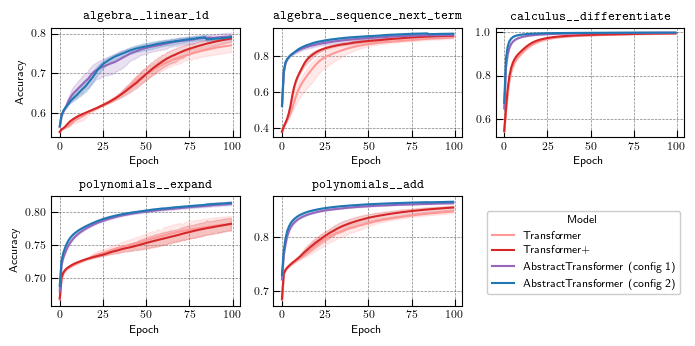

In [494]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Training)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_trainacc.pdf')

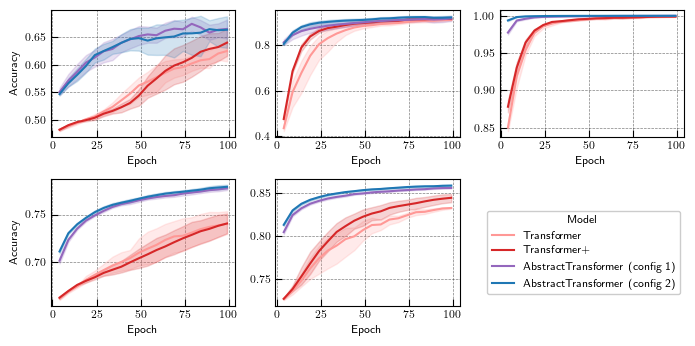

In [495]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Interpolation)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_interpolation.pdf')

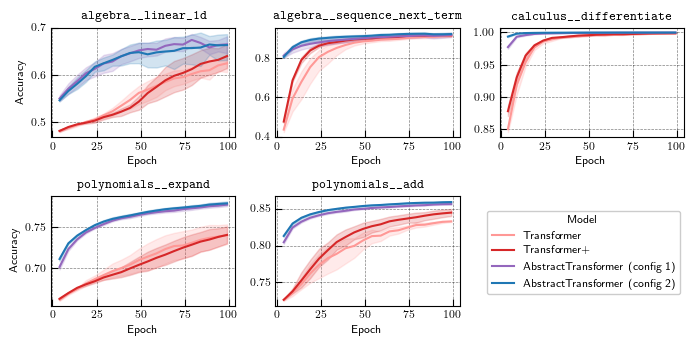

In [496]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Extrapolation)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_extrapolation.pdf')

## Language Modeling: Tiny Stories

In [505]:
figure_data = pd.read_csv('figure_data/tiny_stories/run_histories.csv')
figure_data.head()

,_step,train/perplexity,_runtime,mfu,lr,val/loss,train/loss,tokens,val/perplexity,iter,...,wandb_log,trainable_symbols,vocab_size,rca_type,learning_rate,eval_iters,beta2,group,name,Generated Samples
0,0,38133.015625,20.951026,-100.000000,0.001,10.549802,10.548820,0.000000e+00,38170.359375,0,...,True,True,32000,standard,0.001,100,0.95,NaN,sa=4; rca=4; d=64; L=6; rca_type=standard; sym...,NaN
1,2000,8.594155,400.077009,7.431961,0.001,2.151742,2.150809,2.621440e+08,8.602150,2000,...,True,True,32000,standard,0.001,100,0.95,NaN,sa=4; rca=4; d=64; L=6; rca_type=standard; sym...,NaN
2,4000,7.386282,779.378515,7.437579,0.001,1.999664,1.999366,5.242880e+08,7.388489,4000,...,True,True,32000,standard,0.001,100,0.95,NaN,sa=4; rca=4; d=64; L=6; rca_type=standard; sym...,NaN
3,6000,6.926795,1158.593294,7.431149,0.001,1.935407,1.935144,7.864320e+08,6.928636,6000,...,True,True,32000,standard,0.001,100,0.95,NaN,sa=4; rca=4; d=64; L=6; rca_type=standard; sym...,NaN
4,8000,6.632045,1537.587801,7.436633,0.001,1.891598,1.891663,1.048576e+09,6.631609,8000,...,True,True,32000,standard,0.001,100,0.95,NaN,sa=4; rca=4; d=64; L=6; rca_type=standard; sym...,NaN


In [506]:
def get_model_name(row):
    if row.rca == 0:
        return f'Transformer ($n_h^{{sa}}={row.sa}, n_h^{{ra}}={row.rca}$)'
    else:
        # return f"AbstractTransformer [{row['Symbol Type']}, symm={row['Symmetric RA']}] ($n_h^{{sa}} = {row.sa}, n_h^{{ra}}={row.rca}$)"
        return f"AbstractTransformer ($n_h^{{sa}}={row.sa}, n_h^{{ra}}={row.rca}$)"

In [507]:
figure_data = figure_data.rename(columns={'symbol_type': 'Symbol Type', 'symmetric_rels': 'Symmetric RA'})

figure_data.loc[figure_data['rca']==0, 'Symbol Type'] = 'NA'
figure_data.loc[figure_data['rca']==0, 'Symmetric RA'] = 'NA'

figure_data['Model'] = pd.Categorical(figure_data.apply(get_model_name, axis=1), models, ordered=True)
sym_map = {'sym_attn': 'Symbolic Attention', 'pos_relative': 'Position-Relative Symbols'}
figure_data['Symbol Type'] = pd.Categorical(figure_data['Symbol Type'].map(sym_map), sym_map.values(), ordered=True)

In [508]:
# bar plot figure
color_map_ = {
    'Transformer ($n_h^{sa}=8, n_h^{ra}=0$)': cmap(6), # red
    f'{our_model_name} ($n_h^{{sa}}=6, n_h^{{ra}}=2$)': cmap(8), # purple
    f'{our_model_name} ($n_h^{{sa}}=4, n_h^{{ra}}=4$)': cmap(0), # blue
    # 'Transformer+': cmap(4),
    }

models = color_map_.keys()

In [509]:
def filter_data(figure_data, d_models=None, layers=None, filter_first_step=False, filter_transformer=False, symbol_types=None, symmetry=None, rca_types=None):
    filter_ = ~figure_data.index.isna()
    if d_models is not None:
        filter_ = filter_ & (figure_data['d_model'].isin(d_models))
    if layers is not None:
        filter_ = filter_ & (figure_data['n_layers'].isin(layers))
    if filter_transformer:
        filter_ = filter_ & (figure_data['rca'] > 0)
    if filter_first_step:
        filter_ = filter_ & (figure_data['_step'] > 0)
    if symbol_types is not None:
        symbol_types = [sym_map[s] for s in symbol_types]
        filter_ = filter_ & ((figure_data['rca'] == 0) | figure_data['Symbol Type'].isin(symbol_types))
    if symmetry is not None:
        filter_ = filter_ & ((figure_data['rca'] == 0) | figure_data['Symmetric RA'].isin(symmetry))
    if rca_types is not None:
        filter_ = filter_ & ((figure_data['rca'] == 0) | (figure_data['rca_type'].isin(rca_types)))
    return figure_data[filter_]

### Table Summary

In [510]:
metric_cols = ['val/loss', 'val/perplexity']
group_cols = ['d_model', 'n_layers', 'sa', 'rca', 'Symbol Type', 'Symmetric RA']

summary = filter_data(figure_data, rca_types=('disentangled_v2',)).groupby(group_cols)[metric_cols].min().reset_index().dropna(subset=metric_cols)

# filter out certain entries
summary = summary[summary.d_model <= 128]

summary.set_index(['d_model', 'n_layers', 'sa', 'rca', 'Symbol Type', 'Symmetric RA'], inplace=True)
summary[metric_cols]= summary[metric_cols].round(3)
summary

val/loss  \
d_model n_layers sa rca Symbol Type               Symmetric RA             
64      4        4  4   Symbolic Attention        False            1.729   
                                                  True             1.744   
                        Position-Relative Symbols False            1.764   
                                                  True             1.785   
                 6  2   Symbolic Attention        False            1.740   
                                                  True             1.745   
                        Position-Relative Symbols False            1.768   
                                                  True             1.777   
        5        4  4   Symbolic Attention        False            1.692   
                                                  True             1.698   
                 6  2   Symbolic Attention        False            1.692   
                                                  True             1.704   
                        Position-Relative Symbols True             1.730   
        6        4  4   Symbolic Attention        False            1.656   
                                                  True             1.668   
                        Position-Relative Symbols False            1.685   
                                                  True             1.704   
                 6  2   Symbolic Attention        False            1.668   
                                                  True             1.669   
                        Position-Relative Symbols True             1.691   
128     4        4  4   Symbolic Attention        False            1.411   
                                                  True             1.417   
                 6  2   Symbolic Attention        False            1.412   
                                                  True             1.415   
        6        4  4   Symbolic Attention        False           10.533   
                                                  True            10.577   
                 6  2   Symbolic Attention        False            1.351   
                                                  True             1.346   

                                                                val/perplexity  
d_model n_layers sa rca Symbol Type               Symmetric RA                  
64      4        4  4   Symbolic Attention        False                  5.639  
                                                  True                   5.722  
                        Position-Relative Symbols False                  5.840  
                                                  True                   5.963  
                 6  2   Symbolic Attention        False                  5.697  
                                                  True                   5.727  
                        Position-Relative Symbols False                  5.859  
                                                  True                   5.914  
        5        4  4   Symbolic Attention        False                  5.431  
                                                  True                   5.467  
                 6  2   Symbolic Attention        False                  5.432  
                                                  True                   5.495  
                        Position-Relative Symbols True                   5.640  
        6        4  4   Symbolic Attention        False                  5.239  
                                                  True                   5.303  
                        Position-Relative Symbols False                  5.395  
                                                  True                   5.498  
                 6  2   Symbolic Attention        False                  5.304  
                                                  True                   5.308  
                        Position-Relative Symbols True                   5.424  
1

In [511]:
# write string to file
with open(f'{save_dir}/tiny_stories/tiny_stories_summary.tex', 'w') as f:
    f.write(summary.to_latex())

C:\Users\awnya\AppData\Local\Temp\ipykernel_32364\3485670739.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(summary.to_latex())


### All Plots & Ablations

============================================ d=64; L=4 =============================================
Symbolic Attention & Asymmetric DisRA


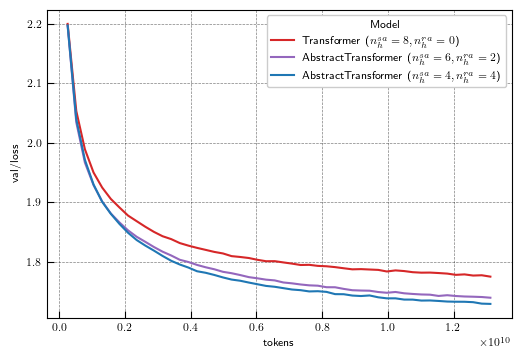

Symbolic Attention & Symmetric DisRA


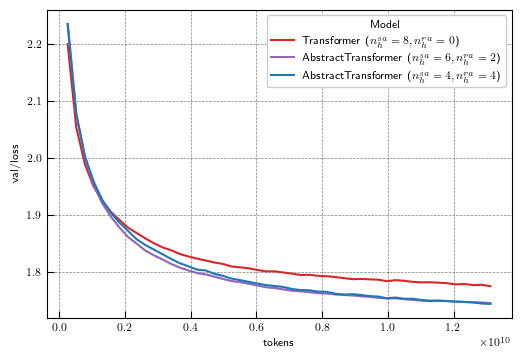

Ablation of Symmetric (Symbolic Attention)


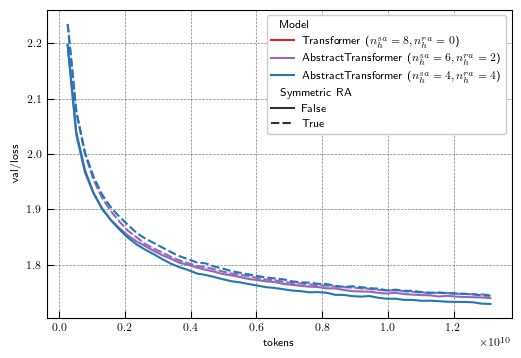

Ablation of Symbol Type (Symmetric DisRA)


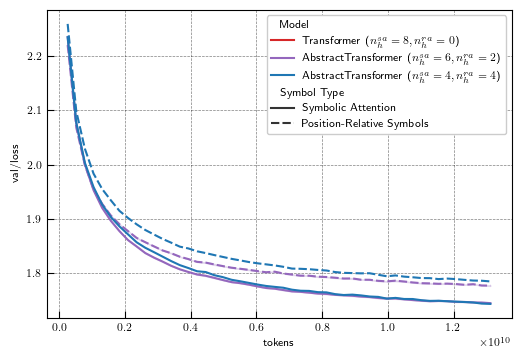

Ablation of Symbol Type (Asymmetric DisRA)


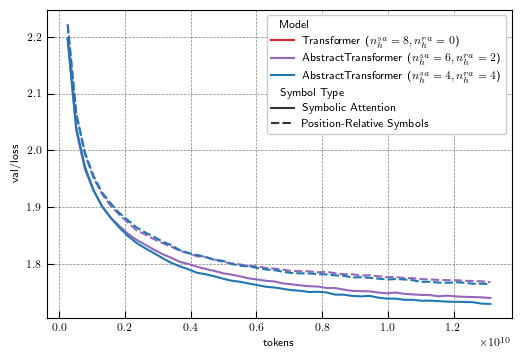

============================================ d=64; L=5 =============================================
Symbolic Attention & Asymmetric DisRA


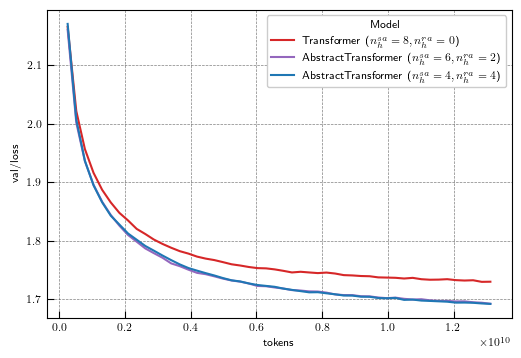

Symbolic Attention & Symmetric DisRA


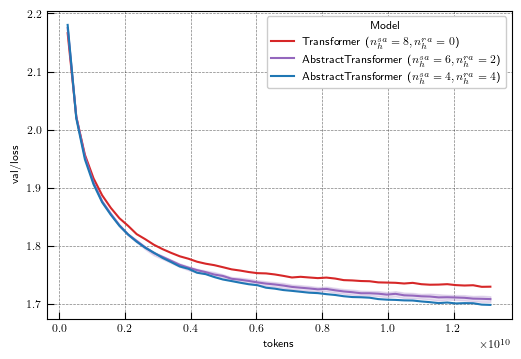

Ablation of Symmetric (Symbolic Attention)


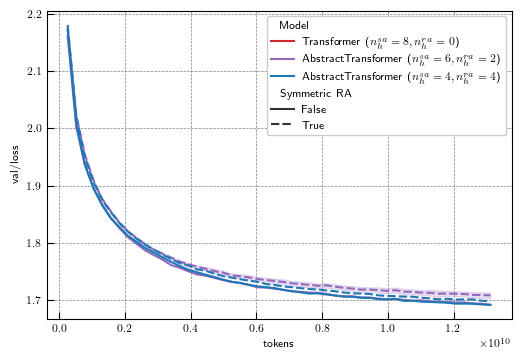

Ablation of Symbol Type (Symmetric DisRA)


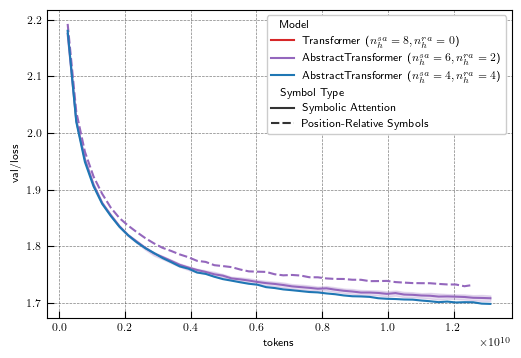

Ablation of Symbol Type (Asymmetric DisRA)


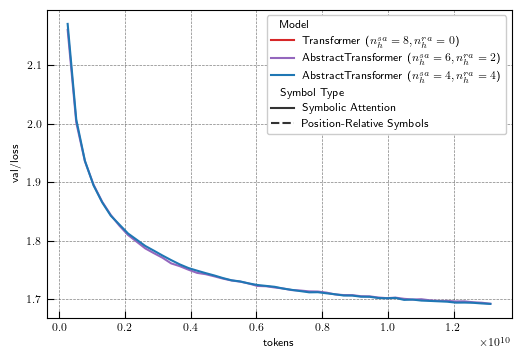

============================================ d=64; L=6 =============================================
Symbolic Attention & Asymmetric DisRA


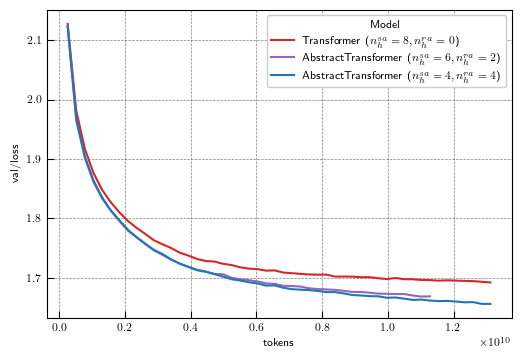

Symbolic Attention & Symmetric DisRA


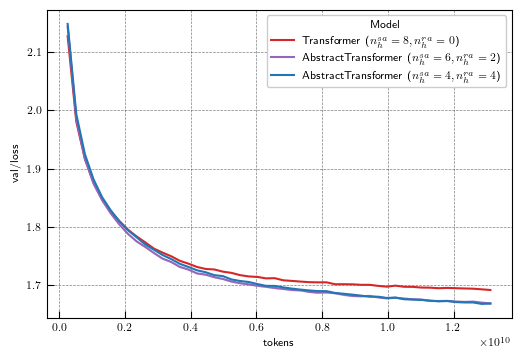

Ablation of Symmetric (Symbolic Attention)


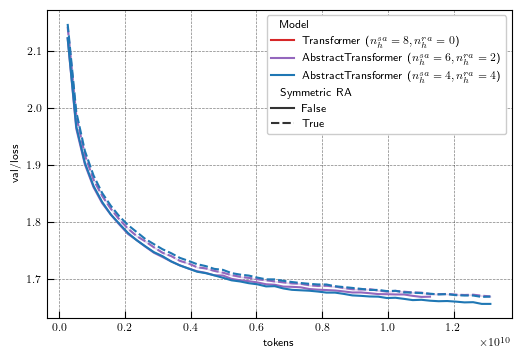

Ablation of Symbol Type (Symmetric DisRA)


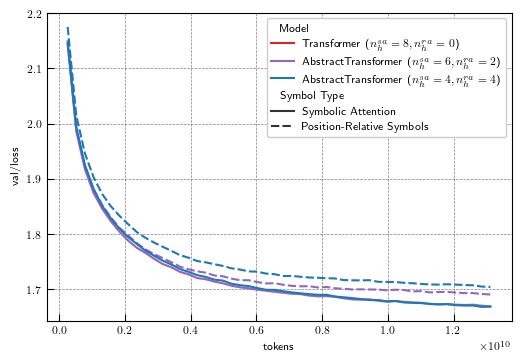

Ablation of Symbol Type (Asymmetric DisRA)


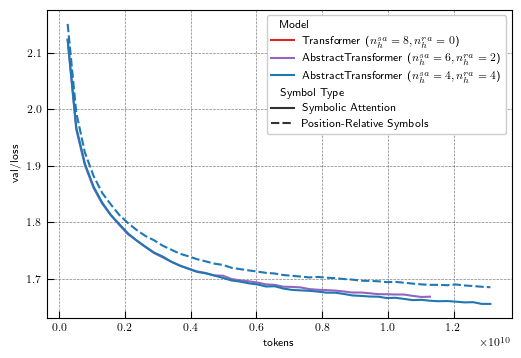

============================================ d=128; L=4 =============================================
Symbolic Attention & Asymmetric DisRA


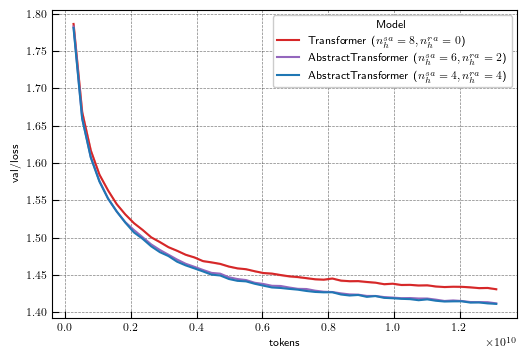

Symbolic Attention & Symmetric DisRA


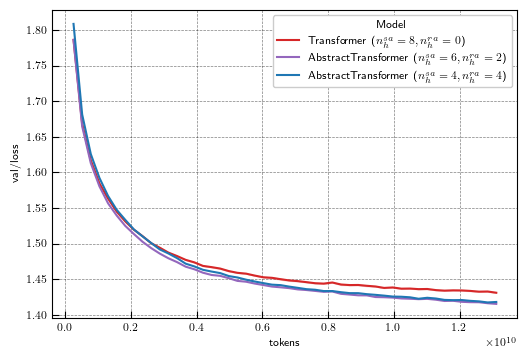

Ablation of Symmetric (Symbolic Attention)


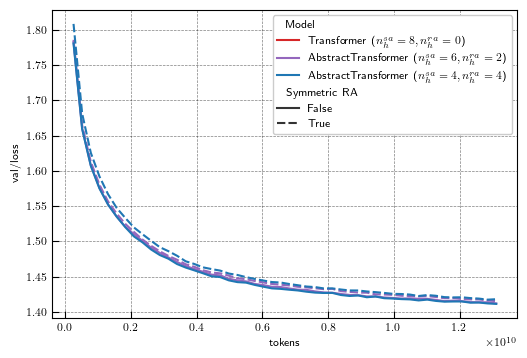

Ablation of Symbol Type (Symmetric DisRA)


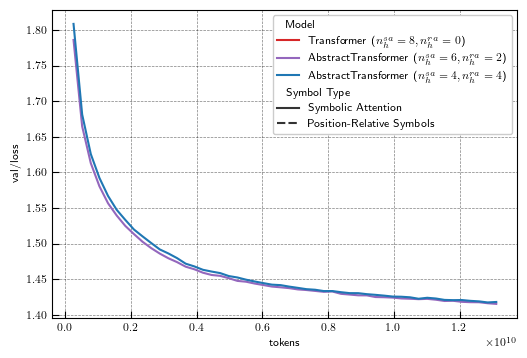

Ablation of Symbol Type (Asymmetric DisRA)


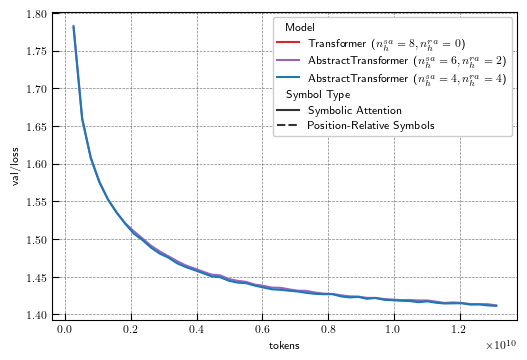

============================================ d=128; L=6 =============================================
Symbolic Attention & Asymmetric DisRA


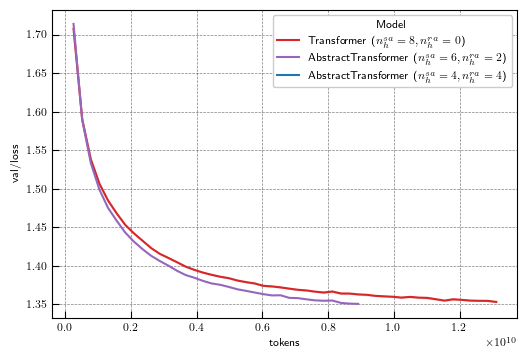

Symbolic Attention & Symmetric DisRA


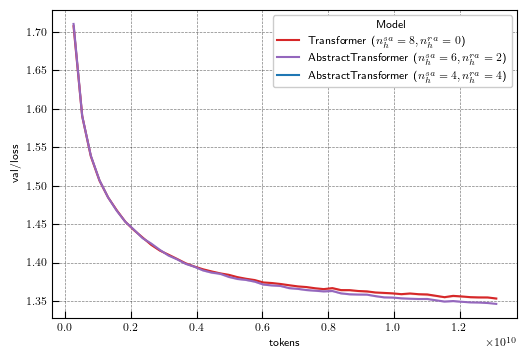

Ablation of Symmetric (Symbolic Attention)


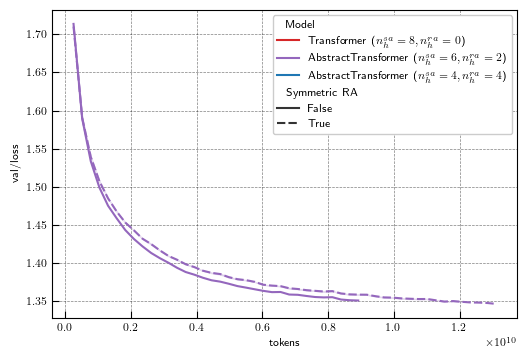

Ablation of Symbol Type (Symmetric DisRA)


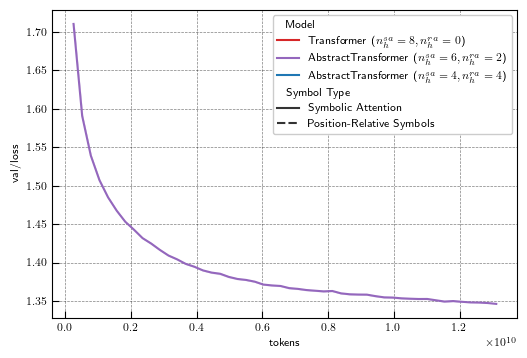

Ablation of Symbol Type (Asymmetric DisRA)


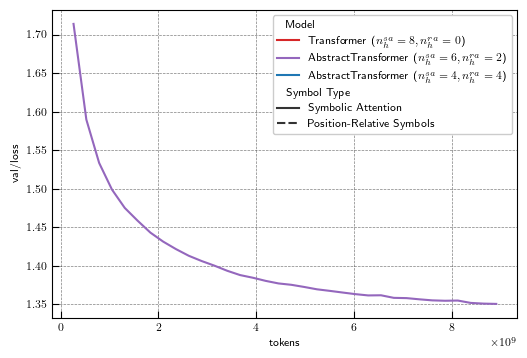

In [512]:
dLs = [(64, 4), (64, 5), (64, 6), (128, 4), (128, 6)]
for d, L in dLs:
    print('='*44 + f' d={d}; L={L} ' + '='*45)
    print('='*100)

    # symbolic attention and asymmetric RA
    print('Symbolic Attention & Asymmetric DisRA')
    fig, ax = plt.subplots(figsize=(6,4))
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True,
        symbol_types=('sym_attn',), symmetry=(False,), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='tokens', y='val/loss', hue='Model', palette=color_map_, ax=ax);
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_symattn_asymra.pdf')
    plt.show()

    # symbolic attention and symmetric RA
    print('Symbolic Attention & Symmetric DisRA')
    fig, ax = plt.subplots(figsize=(6,4))
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True,
        symbol_types=('sym_attn',), symmetry=(True,), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='tokens', y='val/loss', hue='Model', palette=color_map_, ax=ax);
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_symattn_symra.pdf')
    plt.show()

    # ablation of symmetry
    print('Ablation of Symmetric (Symbolic Attention)')
    fig, ax = plt.subplots(figsize=(6,4))
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('sym_attn',), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='tokens', y='val/loss', hue='Model', style='Symmetric RA', palette=color_map_, ax=ax);
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symmetry_symmattn.pdf')
    plt.show()

    # ablation of symbol type; symmetric rel
    print('Ablation of Symbol Type (Symmetric DisRA)')
    fig, ax = plt.subplots(figsize=(6,4))
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('sym_attn', 'pos_relative'), symmetry=(True, ), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='tokens', y='val/loss', hue='Model', style='Symbol Type', palette=color_map_, ax=ax);
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symboltype_symra.pdf')
    plt.show()

    # ablation of symbol type; asymmetric rel
    print('Ablation of Symbol Type (Asymmetric DisRA)')
    fig, ax = plt.subplots(figsize=(6,4))
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('sym_attn', 'pos_relative'), symmetry=(False, ), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='tokens', y='val/loss', hue='Model', style='Symbol Type', palette=color_map_, ax=ax);
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symboltype_asymra.pdf')
    plt.show()

    print('='*100)

## Vision